In [ ]:
!pip install catboost

In [11]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_boston, load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, mean_squared_error, mean_squared_log_error, balanced_accuracy_score
import xgboost as xgb
import catboost as ctb
import lightgbm as lgb

В данном эксперименте мы рассмотрим эффективность алгоритмов **XGBoost**, **CatBoost** и **LightGBM** и подберем лучшие гиперпараметры с помощью **GridSearchCV** на следующих датасетах:


1.   **Boston**. "Игрушечный" датасет из sklearn. (Задача регрессии)
2.   **Breast Cancer**. "Игрушечный" датасет из sklearn. (Задача бинарной классификации)
3.   **House Prices**. https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data?select=train.csv. Необходимо определить цену дома (Задача регрессии)
4.   **Water Quality**. https://www.kaggle.com/adityakadiwal/water-potability. Необходимо определить пригодность воды для питья (Задача бинарной классификации)


#Boston (Задача регрессии)

## Готовим датасет


In [195]:
boston = load_boston()
X = boston.data
y = boston.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [196]:
df = pd.DataFrame(load_boston().data, columns=load_boston().feature_names)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


## GridSearchCV


### XGBoost

In [ ]:
xgb_model = xgb.XGBRegressor(nthread = 4, objective='reg:squarederror')
param_grid = dict(
    max_depth = [4, 5, 6, 7],
    learning_rate = [0.1, 0.01, 0.05],
    n_estimators = [100, 200],
    gamma = [0, 1, 10],
    colsample_bytree = [0.1, 0.5, 1]
)
grid = GridSearchCV(xgb_model, param_grid, verbose=True, scoring='neg_mean_squared_log_error')
grid.fit(X_train, y_train)

print(end='')

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed:  2.3min finished


In [ ]:
print(grid.best_params_)
print(np.sqrt(-grid.best_score_))

{'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200}
0.151604738517858


In [ ]:
print('Best RMSLE Score: {}'.format(np.sqrt(-grid.best_score_)))
print('Test RMSLE: {}'.format(np.sqrt(mean_squared_log_error(y_test, grid.predict(X_test)))))
print('Train RMSLE: {}'.format(np.sqrt(mean_squared_log_error(y_train, grid.predict(X_train)))))

Best RMSLE Score: 0.151604738517858
Test RMSLE: 0.13791926633157803
Train RMSLE: 0.05706154127941335


In [203]:
%time
xgb_model = xgb.XGBRegressor(nthread = 4, objective='reg:squarederror', colsample_bytree = 0.5, gamma = 0, learning_rate = 0.05, max_depth = 4, n_estimators = 200)
xgb_model.fit(X_train, y_train)
print()

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.34 µs



In [202]:
%time
xgb_model.predict(X_test)
print()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs



### CatBoost

In [ ]:
catboost_model = ctb.CatBoostRegressor()
param_grid = dict(
    depth = [4, 5, 6, 7],
    learning_rate = [0.1, 0.01, 0.05],
    n_estimators = [100, 200],
    logging_level = ['Silent']
)
grid = GridSearchCV(catboost_model, param_grid, verbose=True, scoring='neg_mean_squared_log_error')
grid.fit(X_train, y_train)

print(end='')

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   35.5s finished


In [ ]:
print(grid.best_params_)
print(np.sqrt(-grid.best_score_))

{'depth': 4, 'learning_rate': 0.1, 'logging_level': 'Silent', 'n_estimators': 200}
0.15065041990438877


In [ ]:
print('Best RMSLE Score: {}'.format(np.sqrt(-grid.best_score_)))
print('Test RMSLE: {}'.format(np.sqrt(mean_squared_log_error(y_test, grid.predict(X_test)))))
print('Train RMSLE: {}'.format(np.sqrt(mean_squared_log_error(y_train, grid.predict(X_train)))))

Best RMSLE Score: 0.15065041990438877
Test RMSLE: 0.1462265908469752
Train RMSLE: 0.07478413823593054


In [210]:
%time
catboost_model = ctb.CatBoostRegressor(depth = 4, learning_rate = 0.1, logging_level = 'Silent', n_estimators = 200)
catboost_model.fit(X_train, y_train)
print()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 10 µs



In [208]:
%time
catboost_model.predict(X_test)
print()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.68 µs



### LightGBM

In [ ]:
lightgbm_model = lgb.LGBMRegressor()
param_grid = dict(
    num_leaves = [4, 5, 7, 15],
    learning_rate = [0.1, 0.01, 0.05],
    n_estimators = [100, 200],
    logging_level = ['Silent'],
    max_depth = [4, 5, 6, 7, -1]
)
grid = GridSearchCV(lightgbm_model, param_grid, verbose=True, scoring='neg_mean_squared_log_error')
grid.fit(X_train, y_train)

print(end='')

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  1.0min finished


In [ ]:
print(grid.best_params_)
print(np.sqrt(-grid.best_score_))

{'learning_rate': 0.1, 'logging_level': 'Silent', 'max_depth': 4, 'n_estimators': 100, 'num_leaves': 5}
0.16164181552682355


In [ ]:
print('Best RMSLE Score: {}'.format(np.sqrt(-grid.best_score_)))
print('Test RMSLE: {}'.format(np.sqrt(mean_squared_log_error(y_test, grid.predict(X_test)))))
print('Train RMSLE: {}'.format(np.sqrt(mean_squared_log_error(y_train, grid.predict(X_train)))))

Best RMSLE Score: 0.16164181552682355
Test RMSLE: 0.1471731751211182
Train RMSLE: 0.10327598507389145


In [212]:
%time
lightgbm_model = lgb.LGBMRegressor(learning_rate = 0.1, logging_level = 'Silent', max_depth = 4, n_estimators = 100, num_leaves = 5)
lightgbm_model.fit(X_train, y_train)
print()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs



In [213]:
%time
lightgbm_model.predict(X_test)
print()

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.15 µs



##Вывод

Результаты:

| Boston | XGBoost | CatBoost | LightGBM |
| --- | --- | --- | --- |
| Best Parameters| 'colsample_bytree': 0.5, <br /> 'gamma': 0, <br /> 'learning_rate': 0.05, <br /> 'max_depth': 4, <br /> 'n_estimators': 200 | 'depth': 4, <br /> 'learning_rate': 0.1, <br /> 'n_estimators': 200 |  'learning_rate': 0.1, <br /> 'max_depth': 4, <br /> 'n_estimators': 100, <br /> 'num_leaves': 5  |
| Train RMSLE    | 0.0570615 | 0.0747841 | 0.1032759  |
| Test RMSLE     | 0.1379192 | 0.1462266 | 0.1471732  |
| Parameter <br /> Tuning Time      | 2.3min <br /> (1080 iter) | 35.5s <br /> (120 iter) |  1.0min <br /> (600 iter)  |




# Breast Cancer (Задача бинарной классификации)

## Готовим датасет


In [214]:
breast_cancer = load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [215]:
df = pd.DataFrame(load_breast_cancer().data, columns=load_breast_cancer().feature_names)
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [216]:
df.isna().sum()

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
dtype: int64

## GridSearchCV


### XGBoost

In [8]:
xgb_model = xgb.XGBRegressor(nthread = 4, objective='binary:logistic')
param_grid = dict(
    max_depth = [4, 5, 6, 7],
    learning_rate = [0.1, 0.01, 0.05],
    n_estimators = [100, 200],
    gamma = [0, 1, 10],
    colsample_bytree = [0.1, 0.5, 1]
)
grid = GridSearchCV(xgb_model, param_grid, verbose=True, scoring='roc_auc')
grid.fit(X_train, y_train)

print(end='')

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed:  2.9min finished


In [32]:
print(grid.best_params_)
print(grid.best_score_)

{'colsample_bytree': 0.1, 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200}
0.9895905793385328


In [31]:
print('Best Score: {}'.format(grid.best_score_))
print('Test ROC_AUC: {}'.format(roc_auc_score(y_test, grid.predict(X_test))))
print('Train ROC_AUC: {}'.format(roc_auc_score(y_train, grid.predict(X_train))))

Best Score: 0.9895905793385328
Test ROC_AUC: 0.9969135802469136
Train ROC_AUC: 1.0


In [30]:
print('Test balanced accuracy: {}'.format(balanced_accuracy_score(y_test, (grid.predict(X_test)>0.5)*1)))
print('Train balanced accuracy: {}'.format(balanced_accuracy_score(y_train, (grid.predict(X_train)>0.5)*1)))

Test balanced accuracy: 0.9715608465608465
Train balanced accuracy: 0.9966442953020134


In [217]:
%time
xgb_model = xgb.XGBRegressor(nthread = 4, objective='binary:logistic', colsample_bytree = 0.1, gamma = 1, learning_rate = 0.05, max_depth = 4, n_estimators = 200)
xgb_model.fit(X_train, y_train)
print()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs



In [218]:
%time
xgb_model.predict(X_test)
print()

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.3 µs



### CatBoost

In [85]:
catboost_model = ctb.CatBoostClassifier(objective='Logloss')
param_grid = dict(
    depth = [4, 5, 6, 7],
    learning_rate = [0.1, 0.01, 0.05],
    n_estimators = [100, 200],
    logging_level = ['Silent']
)
grid = GridSearchCV(catboost_model, param_grid, verbose=True, scoring='roc_auc')
grid.fit(X_train, y_train)

print(end='')

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  2.5min finished


In [86]:
print(grid.best_params_)
print(grid.best_score_)
# {'depth': 5, 'learning_rate': 0.05, 'logging_level': 'Silent', 'n_estimators': 100}
# 0.9904242083040113

{'depth': 5, 'learning_rate': 0.05, 'logging_level': 'Silent', 'n_estimators': 100}
0.9904242083040113


In [87]:
print('Best Score: {}'.format(grid.best_score_))
print('Test ROC_AUC: {}'.format(roc_auc_score(y_test, grid.predict(X_test))))
print('Train ROC_AUC: {}'.format(roc_auc_score(y_train, grid.predict(X_train))))
# Best Score: 0.9904242083040113
# Test ROC_AUC: 0.9636243386243386
# Train ROC_AUC: 1.0

Best Score: 0.9904242083040113
Test ROC_AUC: 0.9636243386243386
Train ROC_AUC: 1.0


In [88]:
print('Test balanced accuracy: {}'.format(balanced_accuracy_score(y_test, (grid.predict(X_test)>0.5)*1)))
print('Train balanced accuracy: {}'.format(balanced_accuracy_score(y_train, (grid.predict(X_train)>0.5)*1)))
# Test balanced accuracy: 0.9636243386243386
# Train balanced accuracy: 1.0

Test balanced accuracy: 0.9636243386243386
Train balanced accuracy: 1.0


In [223]:
%time
catboost_model = ctb.CatBoostClassifier(depth = 5, learning_rate = 0.05, logging_level = 'Silent', n_estimators = 100)
catboost_model.fit(X_train, y_train)
print()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.54 µs



In [224]:
%time
catboost_model.predict(X_test)
print()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs



### LightGBM

In [78]:
lightgbm_model = lgb.LGBMClassifier(objective='binary')
param_grid = dict(
    num_leaves = [4, 5, 7, 15],
    learning_rate = [0.1, 0.01, 0.05],
    n_estimators = [100, 200],
    logging_level = ['Silent'],
    max_depth = [4, 5, 6, 7, -1]
)
grid = GridSearchCV(lightgbm_model, param_grid, verbose=True, scoring='roc_auc')
grid.fit(X_train, y_train)

print(end='')

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  1.5min finished


In [82]:
print(grid.best_params_)
print(grid.best_score_)

{'learning_rate': 0.1, 'logging_level': 'Silent', 'max_depth': 4, 'n_estimators': 200, 'num_leaves': 7}
0.9906770818672296


In [83]:
print('Best Score: {}'.format(grid.best_score_))
print('Test ROC_AUC: {}'.format(roc_auc_score(y_test, grid.predict(X_test))))
print('Train ROC_AUC: {}'.format(roc_auc_score(y_train, grid.predict(X_train))))

Best Score: 0.9906770818672296
Test ROC_AUC: 0.9543650793650794
Train ROC_AUC: 1.0


In [84]:
print('Test balanced accuracy: {}'.format(balanced_accuracy_score(y_test, (grid.predict(X_test)>0.5)*1)))
print('Train balanced accuracy: {}'.format(balanced_accuracy_score(y_train, (grid.predict(X_train)>0.5)*1)))

Test balanced accuracy: 0.9543650793650793
Train balanced accuracy: 1.0


In [221]:
%time
lightgbm_model = lgb.LGBMClassifier(learning_rate = 0.1, logging_level = 'Silent', max_depth = 4, n_estimators = 200, num_leaves = 7)
lightgbm_model.fit(X_train, y_train)
print()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs



In [222]:
%time
lightgbm_model.predict(X_test)
print()

CPU times: user 0 ns, sys: 3 µs, total: 3 µs
Wall time: 6.91 µs



##Вывод

Результаты:

| Breast Cancer | XGBoost | CatBoost | LightGBM |
| --- | --- | --- | --- |
| Best Parameters| 'colsample_bytree': 0.1,  <br /> 'gamma': 1,  <br />'learning_rate': 0.05,  <br /> 'max_depth': 4, <br /> 'n_estimators': 200 | 'depth': 5, <br /> 'learning_rate': 0.05, <br /> 'n_estimators': 100|  'learning_rate': 0.1, <br /> 'max_depth': 4, <br /> 'n_estimators': 200, <br /> 'num_leaves': 7 |
| Train ROC_AUC   | 1.0       | 1.0       | 1.0  |
| Test ROC_AUC    | 0.9969136 | 0.9636243 | 0.9543650  |
| Parameter <br /> Tuning Time      | 2.9min <br /> (1080 iter) | 2.5min <br /> (120 iter) |  1.5min <br /> (600 iter)  |

# House Prices (Задача регрессии)

## Готовим датасет


In [225]:
df = pd.read_csv('train_House.csv')

In [226]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [227]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [228]:
# REMOVE THE OUTLIERS
df = df.drop(df[(df["GrLivArea"] > 4000) 
                         & (df["SalePrice"] < 200000)].index).reset_index(drop = True)
df = df.drop(df[(df["GarageCars"] > 3) 
                         & (df["SalePrice"] < 300000)].index).reset_index(drop = True)

In [229]:
# FILL THE MISSING VALUES
some_miss_columns = ["PoolQC","MiscFeature","Alley","Fence","FireplaceQu","GarageType","GarageFinish","GarageQual","GarageCond",
                  "BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","MasVnrType","MSSubClass"]

for i in some_miss_columns :
        df[i].fillna("None" , inplace = True)

In [230]:
df["Functional"] = df["Functional"].fillna("Typ")

In [231]:
some_miss_columns2 = ["MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities","MSZoning",
                      "Electrical", "KitchenQual", "SaleType","Exterior1st", "Exterior2nd","MasVnrArea"]
for i in some_miss_columns2:
    df[i].fillna(df[i].mode()[0], inplace = True)

In [232]:
some_miss_columns3 = ["GarageYrBlt", "GarageArea", "GarageCars","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF"]
for i in some_miss_columns3 :
    df[i] = df[i].fillna(0)

In [233]:
df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [234]:
df.isna().sum().nlargest(3) # Избавились от null

Id            0
MSSubClass    0
MSZoning      0
dtype: int64

In [235]:
Nm = ["MSSubClass","MoSold","YrSold"]
for col in Nm:
    df[col] = df[col].astype(str)

In [236]:
# LABEL ENCODING
lbe = LabelEncoder()
encodecolumns = ("FireplaceQu","BsmtQual","BsmtCond","ExterQual","ExterCond","HeatingQC","GarageQual",
                "GarageCond","PoolQC","KitchenQual","BsmtFinType1","BsmtFinType2","Functional","Fence",
                "BsmtExposure","GarageFinish","LandSlope","LotShape","PavedDrive","Street","Alley",
                "CentralAir","MSSubClass","OverallCond","YrSold","MoSold")
for i in encodecolumns :
    lbe.fit(list(df[i].values))
    df[i] = lbe.transform(list(df[i].values))

In [237]:
df = pd.get_dummies(df)
df.head()

,Id,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,...,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,9,65.0,8450,1,1,3,0,7,4,2003,2003,196.0,2,4,2,4,3,2,706,6,0,150,856,0,1,856,854,0,1710,1,0,2,1,3,1,2,8,6,0,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,2,4,80.0,9600,1,1,3,0,6,7,1976,1976,0.0,3,4,2,4,1,0,978,6,0,284,1262,0,1,1262,0,0,1262,0,1,2,0,3,1,3,6,6,1,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,3,9,68.0,11250,1,1,0,0,7,4,2001,2002,162.0,2,4,2,4,2,2,486,6,0,434,920,0,1,920,866,0,1786,1,0,2,1,3,1,2,6,6,1,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,4,10,60.0,9550,1,1,0,0,7,4,1915,1970,0.0,3,4,4,1,3,0,216,6,0,540,756,2,1,961,756,0,1717,1,0,1,0,3,1,2,7,6,1,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,5,9,84.0,14260,1,1,0,0,8,4,2000,2000,350.0,2,4,2,4,0,2,655,6,0,490,1145,0,1,1145,1053,0,2198,1,0,2,1,4,1,2,9,6,1,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [238]:
X = df.drop(axis=1,columns=['SalePrice']).values
y = df.SalePrice.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## GridSearchCV


### XGBoost

In [157]:
xgb_model = xgb.XGBRegressor(nthread = 4, objective='reg:squarederror')
param_grid = dict(
    max_depth = [4, 5, 6, 7],
    learning_rate = [0.1, 0.01, 0.05],
    n_estimators = [100, 200],
    gamma = [0, 1, 10],
    colsample_bytree = [0.1, 0.5, 1]
)
grid = GridSearchCV(xgb_model, param_grid, verbose=True, scoring='neg_mean_squared_log_error')
grid.fit(X_train, y_train)

print(end='')

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed: 12.7min finished


In [160]:
print(grid.best_params_)
print(np.sqrt(-grid.best_score_))

{'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}
0.13303655598121691


In [161]:
print('Best RMSLE Score: {}'.format(np.sqrt(-grid.best_score_)))
print('Test RMSLE: {}'.format(np.sqrt(mean_squared_log_error(y_test, grid.predict(X_test)))))
print('Train RMSLE: {}'.format(np.sqrt(mean_squared_log_error(y_train, grid.predict(X_train)))))

Best RMSLE Score: 0.13303655598121691
Test RMSLE: 0.11923533348028849
Train RMSLE: 0.04949153954439591


In [239]:
%time
xgb_model = xgb.XGBRegressor(nthread = 4, objective='reg:squarederror', colsample_bytree = 0.5, gamma = 0, learning_rate = 0.1, max_depth = 4, n_estimators = 200)
xgb_model.fit(X_train, y_train)
print()

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs



In [240]:
%time
xgb_model.predict(X_test)
print()

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.68 µs



### CatBoost

In [162]:
catboost_model = ctb.CatBoostRegressor()
param_grid = dict(
    depth = [4, 5, 6, 7],
    learning_rate = [0.1, 0.01, 0.05],
    n_estimators = [100, 200],
    logging_level = ['Silent']
)
grid = GridSearchCV(catboost_model, param_grid, verbose=True, scoring='neg_mean_squared_log_error')
grid.fit(X_train, y_train)

print(end='')

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.9min finished


In [163]:
print(grid.best_params_)
print(np.sqrt(-grid.best_score_))

{'depth': 5, 'learning_rate': 0.1, 'logging_level': 'Silent', 'n_estimators': 200}
0.13009131780597433


In [164]:
print('Best RMSLE Score: {}'.format(np.sqrt(-grid.best_score_)))
print('Test RMSLE: {}'.format(np.sqrt(mean_squared_log_error(y_test, grid.predict(X_test)))))
print('Train RMSLE: {}'.format(np.sqrt(mean_squared_log_error(y_train, grid.predict(X_train)))))

Best RMSLE Score: 0.13009131780597433
Test RMSLE: 0.11563716787776686
Train RMSLE: 0.07826305948392215


### LightGBM

In [165]:
lightgbm_model = lgb.LGBMRegressor()
param_grid = dict(
    num_leaves = [4, 5, 7, 15],
    learning_rate = [0.1, 0.01, 0.05],
    n_estimators = [100, 200],
    logging_level = ['Silent'],
    max_depth = [4, 5, 6, 7, -1]
)
grid = GridSearchCV(lightgbm_model, param_grid, verbose=True, scoring='neg_mean_squared_log_error')
grid.fit(X_train, y_train)

print(end='')

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  2.7min finished


In [166]:
print(grid.best_params_)
print(np.sqrt(-grid.best_score_))

{'learning_rate': 0.1, 'logging_level': 'Silent', 'max_depth': 4, 'n_estimators': 200, 'num_leaves': 5}
0.1312329859748449


In [167]:
print('Best RMSLE Score: {}'.format(np.sqrt(-grid.best_score_)))
print('Test RMSLE: {}'.format(np.sqrt(mean_squared_log_error(y_test, grid.predict(X_test)))))
print('Train RMSLE: {}'.format(np.sqrt(mean_squared_log_error(y_train, grid.predict(X_train)))))

Best RMSLE Score: 0.1312329859748449
Test RMSLE: 0.11805369003382228
Train RMSLE: 0.08989717451374557


##Вывод

Результаты:

| House Prices | XGBoost | CatBoost | LightGBM |
| --- | --- | --- | --- |
| Best Parameters| 'colsample_bytree': 0.5,  <br /> 'gamma': 0,  <br />'learning_rate': 0.1,  <br /> 'max_depth': 4,  <br /> 'n_estimators': 200 | 'depth': 5, <br />'learning_rate': 0.1, <br /> 'n_estimators': 200 |  'learning_rate': 0.1,  <br /> 'max_depth': 4,  <br /> 'n_estimators': 200,  <br />'num_leaves': 5 |
| Train RMSLE    | 0.0494916 | 0.0782630 | 0.0898972  |
| Test RMSLE     | 0.1192353 | 0.1156372 | 0.1180537  |
| Parameter <br /> Tuning Time      | 12.7min <br /> (1080 iter) | 1.9min <br /> (120 iter) |  2.7min <br /> (600 iter)  |

# Water Quality (Задача бинарной классификации)

## Готовим датасет


In [241]:
df = pd.read_csv('water_potability.csv')
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [242]:
df.isna().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [243]:
df = df.fillna(df.mean()) # Заменим все NaN средним значением

In [244]:
df.isna().sum().sum() # Избавились от всех NaN-ов

0

In [245]:
X = df.drop(axis=1, columns=['Potability']).values
y = df.Potability.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## GridSearchCV


### XGBoost

In [183]:
xgb_model = xgb.XGBRegressor(nthread = 4, objective='binary:logistic')
param_grid = dict(
    max_depth = [4, 5, 6, 7],
    learning_rate = [0.1, 0.01, 0.05],
    n_estimators = [100, 200],
    gamma = [0, 1, 10],
    colsample_bytree = [0.1, 0.5, 1]
)
grid = GridSearchCV(xgb_model, param_grid, verbose=True, scoring='roc_auc')
grid.fit(X_train, y_train)

print(end='')

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed:  6.3min finished


In [184]:
print(grid.best_params_)
print(grid.best_score_)

{'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200}
0.649405852506617


In [185]:
print('Best Score: {}'.format(grid.best_score_))
print('Test ROC_AUC: {}'.format(roc_auc_score(y_test, grid.predict(X_test))))
print('Train ROC_AUC: {}'.format(roc_auc_score(y_train, grid.predict(X_train))))

Best Score: 0.649405852506617
Test ROC_AUC: 0.678191230261002
Train ROC_AUC: 0.910857089319969


In [186]:
print('Test balanced accuracy: {}'.format(balanced_accuracy_score(y_test, (grid.predict(X_test)>0.5)*1)))
print('Train balanced accuracy: {}'.format(balanced_accuracy_score(y_train, (grid.predict(X_train)>0.5)*1)))

Test balanced accuracy: 0.5790290582848439
Train balanced accuracy: 0.7260943474725917


In [246]:
%time
xgb_model = xgb.XGBRegressor(nthread = 4, objective='binary:logistic', colsample_bytree = 1, gamma = 0, learning_rate = 0.01, max_depth = 7, n_estimators = 200)
xgb_model.fit(X_train, y_train)
print()

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.78 µs



In [247]:
%time
xgb_model.predict(X_test)
print()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs



### CatBoost

In [187]:
catboost_model = ctb.CatBoostClassifier(objective='Logloss')
param_grid = dict(
    depth = [4, 5, 6, 7],
    learning_rate = [0.1, 0.01, 0.05],
    n_estimators = [100, 200],
    logging_level = ['Silent']
)
grid = GridSearchCV(catboost_model, param_grid, verbose=True, scoring='roc_auc')
grid.fit(X_train, y_train)

print(end='')

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.1min finished


In [188]:
print(grid.best_params_)
print(grid.best_score_)
# {'depth': 5, 'learning_rate': 0.05, 'logging_level': 'Silent', 'n_estimators': 100}
# 0.9904242083040113

{'depth': 7, 'learning_rate': 0.01, 'logging_level': 'Silent', 'n_estimators': 200}
0.680836365477516


In [189]:
print('Best Score: {}'.format(grid.best_score_))
print('Test ROC_AUC: {}'.format(roc_auc_score(y_test, grid.predict(X_test))))
print('Train ROC_AUC: {}'.format(roc_auc_score(y_train, grid.predict(X_train))))
# Best Score: 0.9904242083040113
# Test ROC_AUC: 0.9636243386243386
# Train ROC_AUC: 1.0

Best Score: 0.680836365477516
Test ROC_AUC: 0.5795139534677756
Train ROC_AUC: 0.6661803517664545


In [190]:
print('Test balanced accuracy: {}'.format(balanced_accuracy_score(y_test, (grid.predict(X_test)>0.5)*1)))
print('Train balanced accuracy: {}'.format(balanced_accuracy_score(y_train, (grid.predict(X_train)>0.5)*1)))
# Test balanced accuracy: 0.9636243386243386
# Train balanced accuracy: 1.0

Test balanced accuracy: 0.5795139534677756
Train balanced accuracy: 0.6661803517664545


### LightGBM

In [191]:
lightgbm_model = lgb.LGBMClassifier(objective='binary')
param_grid = dict(
    num_leaves = [4, 5, 7, 15],
    learning_rate = [0.1, 0.01, 0.05],
    n_estimators = [100, 200],
    logging_level = ['Silent'],
    max_depth = [4, 5, 6, 7, -1]
)
grid = GridSearchCV(lightgbm_model, param_grid, verbose=True, scoring='roc_auc')
grid.fit(X_train, y_train)

print(end='')

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  1.8min finished


In [192]:
print(grid.best_params_)
print(grid.best_score_)
#{'learning_rate': 0.1, 'logging_level': 'Silent', 'max_depth': 4, 'n_estimators': 200, 'num_leaves': 7}
#0.9906770818672296

{'learning_rate': 0.05, 'logging_level': 'Silent', 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 15}
0.6363709383587495


In [193]:
print('Best Score: {}'.format(grid.best_score_))
print('Test ROC_AUC: {}'.format(roc_auc_score(y_test, grid.predict(X_test))))
print('Train ROC_AUC: {}'.format(roc_auc_score(y_train, grid.predict(X_train))))
# Best Score: 0.9906770818672296
# Test ROC_AUC: 0.9543650793650794
# Train ROC_AUC: 1.0


Best Score: 0.6363709383587495
Test ROC_AUC: 0.599474364765169
Train ROC_AUC: 0.7313282867741403


In [194]:
print('Test balanced accuracy: {}'.format(balanced_accuracy_score(y_test, (grid.predict(X_test)>0.5)*1)))
print('Train balanced accuracy: {}'.format(balanced_accuracy_score(y_train, (grid.predict(X_train)>0.5)*1)))
# Test balanced accuracy: 0.9543650793650793
# Train balanced accuracy: 1.0

Test balanced accuracy: 0.599474364765169
Train balanced accuracy: 0.7313282867741403


##Вывод

Результаты:

| Breast Cancer | XGBoost | CatBoost | LightGBM |
| --- | --- | --- | --- |
| Best Parameters| 'colsample_bytree': 0.1,  <br /> 'gamma': 1,  <br />'learning_rate': 0.05,  <br /> 'max_depth': 4, <br /> 'n_estimators': 200 | 'depth': 5, <br /> 'learning_rate': 0.05, <br /> 'n_estimators': 100|  'learning_rate': 0.1, <br /> 'max_depth': 4, <br /> 'n_estimators': 200, <br /> 'num_leaves': 7 |
| Train ROC_AUC   | 0.9108571       | 0.6661803 | 0.7313283  |
| Test ROC_AUC    | 0.6781912       | 0.5795139 | 0.5994744  |
| Parameter <br /> Tuning Time      | 1.8min <br /> (1080 iter) | 1.1min <br /> (120 iter) |  1.8min <br /> (600 iter)  |

Такие результаты вполне нормальны для этого датасета. Почти все примеры кода в соответствующем соревновании Kaggle не достигают точности на тестовых данных больше 0.65.

# Результаты

Результаты можно представить в следующем виде:
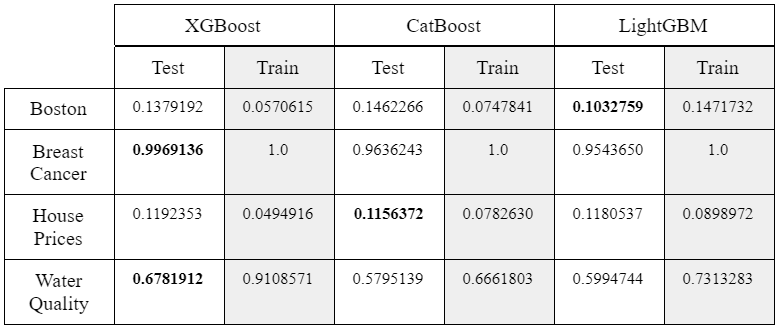


Как видим XGBoost показал себя довольно неплохо на задачах бинарной классификации. Но для регрессии лучше выбрать CatBoost или LightGBM.